In [100]:
import numpy as np
import math as mp

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['savefig.dpi'] = 500

def bestSaveFig(name):
    plt.savefig(name, bbox_inches = 'tight', pad_inches = 0.1)

#\left(\right)

In [101]:
def plot_afm_tip_profile(h, theta_front, theta_back):
    # Convert angles to radians
    theta_front_rad = np.radians(theta_front)
    theta_back_rad = np.radians(theta_back)

    # x-displacement from center at the base of the tip
    x_front = np.tan(theta_front_rad) * h
    x_back = np.tan(theta_back_rad) * h

    # Define coordinates
    x_coords = [-x_back, 0, x_front]
    y_coords = [h, 0, h]

    # Plotting
    plt.figure(figsize=(6, 8))
    plt.plot(x_coords[:2], y_coords[:2], label='Back side')
    plt.plot(x_coords[1:], y_coords[1:], label='Front side')
    plt.title("AFM Tip Profile")
    plt.xlabel("Lateral Position (μm)")
    plt.ylabel("Height (μm)")
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.legend()
    plt.show()


def tip_width_at_height(z, h, theta_front, theta_back):
    if z < 0 or z > h:
        raise ValueError("z must be between 0 and h")
    theta_front_rad = np.radians(theta_front)
    theta_back_rad = np.radians(theta_back)
    width = np.tan(theta_front_rad) * z + np.tan(theta_back_rad) * z
    return width


def tip_displacement_at_height(z, h, theta_front, theta_back):
    if z < 0 or z > h:
        raise ValueError("z must be between 0 and h")
    theta_front_rad = np.radians(theta_front)
    theta_back_rad = np.radians(theta_back)
    x_front = np.tan(theta_front_rad) * z
    x_back = -np.tan(theta_back_rad) * z
    return x_back, x_front  # Left and right edge positions


def simulate_afm_scan(surface_x, surface_z, h, theta_front, theta_back):
    """
    Simulates AFM tip scanning along a surface from left to right.

    Parameters:
    - surface_x: 1D array of x positions
    - surface_z: 1D array of surface heights corresponding to surface_x
    - h: tip height (μm)
    - theta_front: front angle from vertical (degrees)
    - theta_back: back angle from vertical (degrees)

    Returns:
    - scan_heights: 1D array of tip heights as measured by the AFM
    """

    # Convert angles to radians and compute half-widths
    theta_front_rad = np.radians(theta_front)
    theta_back_rad = np.radians(theta_back)

    # Tip extents
    front_extent = np.tan(theta_front_rad) * h
    back_extent = np.tan(theta_back_rad) * h

    # Result array
    scan_heights = []

    dx = surface_x[1] - surface_x[0]  # assume uniform spacing
    window_size = int(np.ceil((front_extent + back_extent) / dx))

    for i in range(len(surface_x)):
        x_center = surface_x[i]

        # Determine bounds of tip footprint on surface
        x_start = x_center - back_extent
        x_end = x_center + front_extent

        # Find indices within the footprint
        idxs = np.where((surface_x >= x_start) & (surface_x <= x_end))[0]

        if len(idxs) == 0:
            scan_heights.append(np.nan)
            continue

        # To be in contact, the tip must be high enough so that:
        # The surface is always below the tip envelope.
        # So we compute the minimum height `z` such that for all x:
        #   z >= surface(x') + slope * |x' - x_center|
        x_local = surface_x[idxs] - x_center
        z_required = []

        for x_off, s_z in zip(x_local, surface_z[idxs]):
            if x_off >= 0:
                # front side
                slope = np.tan(theta_front_rad)
            else:
                # back side
                slope = np.tan(theta_back_rad)
            z_required.append(s_z + slope * abs(x_off))

        # The tip must be at least this high to not intersect the surface
        tip_height = max(z_required)
        scan_heights.append(tip_height)

    return np.array(scan_heights)


def plot_afm_simulation(surface_x, surface_z, scan_z):
    plt.figure(figsize=(10, 4))
    plt.plot(surface_x, surface_z, label="Surface Profile", color='gray')
    plt.plot(surface_x, scan_z, label="AFM Tip Height", color='red')
    plt.xlabel("Position (μm)")
    plt.ylabel("Height (μm)")
    plt.title("AFM Scan Simulation")
    plt.legend()
    plt.grid(True)
    plt.show()

In [102]:
def custom_step_function(x):
    result = np.where(x < 0, 1, np.where(x > 0, 0, 0.5))
    return result

def parameterize_curve(x, y, pointSpace):
    # Step 1: Calculate arc length between consecutive points
    dx = np.diff(x)
    dy = np.diff(y)
    segment_lengths = np.sqrt(dx**2 + dy**2)
    arc_lengths = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    # Step 2: Total length and number of output points
    total_length = arc_lengths[-1]
    num_points = int(np.floor(total_length / pointSpace)) + 1
    uniform_arc_lengths = np.linspace(0, total_length, num_points)
    
    # Step 3: Interpolate x and y based on arc length
    x_new = np.interp(uniform_arc_lengths, arc_lengths, x)
    y_new = np.interp(uniform_arc_lengths, arc_lengths, y)
    
    return x_new, y_new

def compute_normals(x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    # Compute tangent vectors using central differences
    dx = np.gradient(x)
    dy = np.gradient(y)
    
    # Normalize tangents
    tangent_mags = np.sqrt(dx**2 + dy**2)
    tx = dx / tangent_mags
    ty = dy / tangent_mags

    # Rotate tangents by 90° to get normals
    nx = -ty
    ny = tx
    
    normals = np.stack((nx, ny), axis=-1)  # shape (N, 2)
    return normals

def offset_curve_by_normals(x, y, thickness):
    normals = compute_normals(x, y)
    x_offset = x + thickness * normals[:, 0]
    y_offset = y + thickness * normals[:, 1]
    return x_offset, y_offset

In [107]:
#plot_afm_tip_profile(h=10, theta_front=25, theta_back=15)
tip_width_at_height(z=0.100, h=10, theta_front=25, theta_back=15)

0.07342568505861213

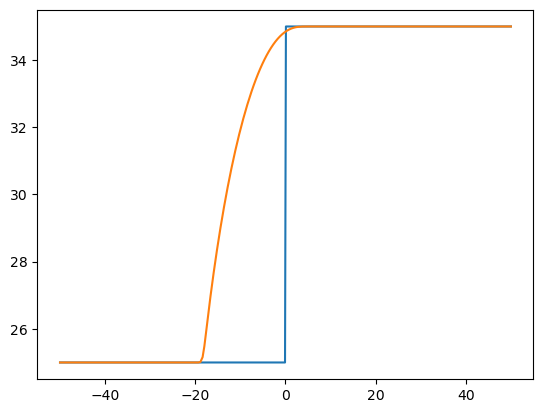

In [41]:
vec = np.linspace(-50,50,num=1001)
step = 10-10 * custom_step_function(vec)
step1 = 10 * custom_step_function(vec+10)
step2 = 10 - 10 * custom_step_function(vec-10)
stept = step1 + step2
dthickness = 5e-5
dParam = 5e-1

totThickness = 25
iterations = int(totThickness / dthickness)

x = vec
y = step

for counter in range(iterations):
    x, y = parameterize_curve(x, y, dParam)
    x, y = offset_curve_by_normals(x, y, dthickness)

plt.plot(vec, step + totThickness)
#plt.plot(vec, stept + totThickness)
plt.plot(x, y)
plt.show()

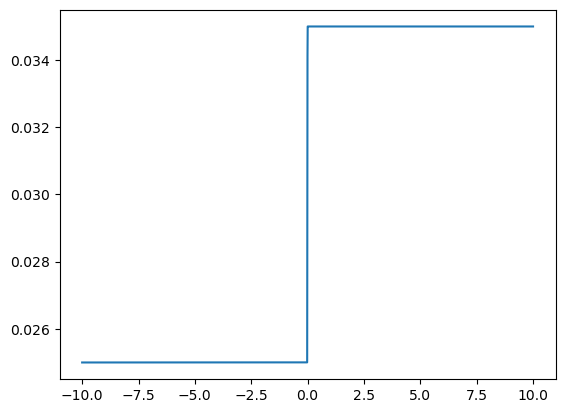

In [46]:
xUse = x
zUse = y

xo = xUse * 1e-3
zo = zUse * 1e-3

xDomain = np.concatenate(([-10.0], xo, [10]))
zDomain = np.concatenate(([0.025], zo, [0.035]))

xNew = np.linspace(min(xDomain), max(xDomain), int((max(xDomain)-min(xDomain)) / (dParam * 1e-3)))
zNew = np.interp(xNew, xDomain, zDomain)

xu = xNew
zu = zNew

# Tip parameters
h = 10  # microns
theta_front = 25  # degrees
theta_back = 15  # degrees

# Run simulation
tip_heights = simulate_afm_scan(xu, zu, h, theta_front, theta_back)

# Plot
#plot_afm_simulation(xu, zu, tip_heights)

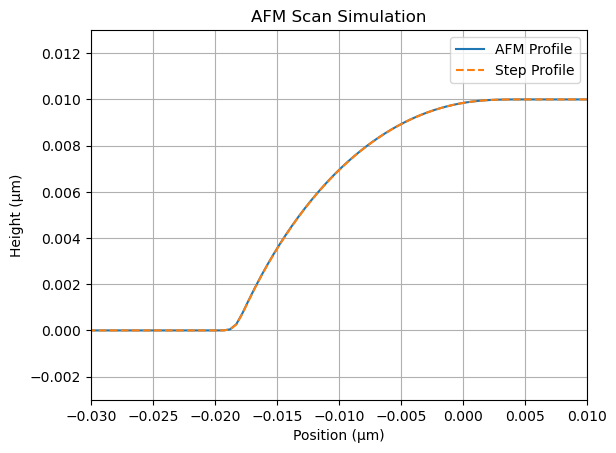

In [99]:
plt.plot(np.subtract(xu,-4.6626), np.subtract(tip_heights, tip_heights[0]), label = "AFM Profile")
plt.plot(xu, np.subtract(zu, zu[0]), ls = "dashed", label = "Step Profile")
plt.ylim((-0.003,0.013))
plt.xlim((-0.03, 0.010))

plt.xlabel("Position (μm)")
plt.ylabel("Height (μm)")
plt.title("AFM Scan Simulation")
plt.legend()
plt.grid(True)
#bestSaveFig("AFMScan_step_29may2025.png")